[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Komatsu-T/Samples/blob/main/deep_learning/graph_neural_network/Graph_classification_2.ipynb)

# Sample of ENZYME dataset graph classification

In [1]:
# --------------------------------------------------
# Install
# --------------------------------------------------
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.7 MB/s eta 0:00:00


In [2]:
# --------------------------------------------------
# Libraries
# --------------------------------------------------
import pandas as pd
import numpy as np
import copy
from tqdm import tqdm
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import multiprocessing
import scipy.linalg

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import GINConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_max_pool
from torch_geometric.nn import TopKPooling
from torch_geometric.utils import scatter
from torch_geometric.utils import to_networkx
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset

Processing...
Done!


Number of graphs: 600
Dimension of node features: 3
Number of graph label types: 6
  - Number of data with label 0: 100
  - Number of data with label 1: 100
  - Number of data with label 2: 100
  - Number of data with label 3: 100
  - Number of data with label 4: 100
  - Number of data with label 5: 100


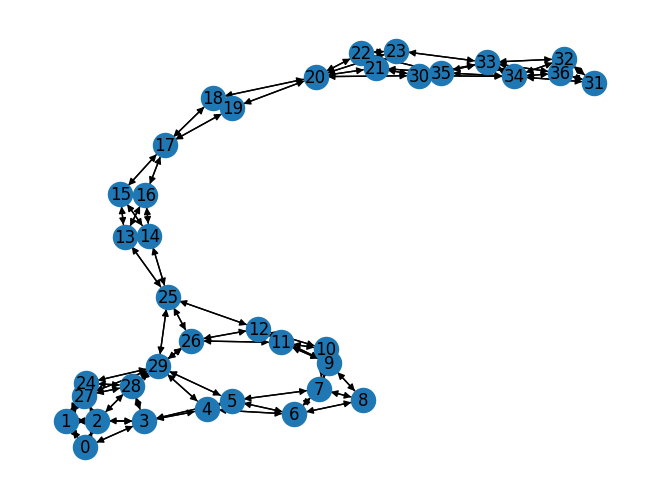

In [3]:
# --------------------------------------------------
# Load dataset
# --------------------------------------------------

# Load ENZYMES datset
dataset = TUDataset(root='', name='ENZYMES')

# Explanation and show sample graph
idx = 0
sample_data = dataset[idx]
graph_labels = [dataset[i].y.item() for i in range(len(dataset))]

print(f"Number of graphs: {len(dataset)}")
print(f"Dimension of node features: {sample_data.x.shape[1]}")
print(f'Number of graph label types: {len(np.unique(graph_labels))}')
for i in np.unique(graph_labels):
    print(f"  - Number of data with label {i}: {np.sum([k==i for k in graph_labels])}")
nx.draw(to_networkx(sample_data), with_labels = True)

# CPU or GPU

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cpu


In [5]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Train-test split

In [6]:
# --------------------------------------------------
# Split
# --------------------------------------------------

# Data split
n_datasize = len(dataset)
n_train = 500
n_test = n_datasize - n_train

data_index = np.arange(n_datasize)
rng = np.random.default_rng(seed = 18)
rng.shuffle(data_index)

train_dataset = dataset[data_index[:n_train]]
test_dataset = dataset[data_index[n_train:]]

# Show data labels
def show_labels(dataset, datatype):
    label_list = dataset.y
    print("--------------"+datatype+"--------------")
    print(f"Number of graphs: {len(dataset)}")
    for i in label_list.unique():
        print(f"  - Number of data with label {int(i)}: {int((label_list==i).sum())}")
    print("")
show_labels(train_dataset, 'train dataset')
show_labels(test_dataset, 'test dataset')

--------------train dataset--------------
Number of graphs: 500
  - Number of data with label 0: 82
  - Number of data with label 1: 86
  - Number of data with label 2: 81
  - Number of data with label 3: 83
  - Number of data with label 4: 83
  - Number of data with label 5: 85

--------------test dataset--------------
Number of graphs: 100
  - Number of data with label 0: 18
  - Number of data with label 1: 14
  - Number of data with label 2: 19
  - Number of data with label 3: 17
  - Number of data with label 4: 17
  - Number of data with label 5: 15



# Initialize data for model evaluation result

In [7]:
model_result = pd.DataFrame()

# Baseline model
#### Graph embedding: Sum of node features (Embedding represents the number of each atom included in the graph)
#### Classification model: MLP

In [8]:
# --------------------------------------------------
# Settings
# --------------------------------------------------
batch_size = 32
lr = 0.001
epochs = 500

In [9]:
# --------------------------------------------------
# Data processing
# --------------------------------------------------

# Caluculate sum of node features
train_graph_embedding = [train_dataset[i].x.sum(axis = 0).view(1, -1) for i in range(len(train_dataset))]
test_graph_embedding = [test_dataset[i].x.sum(axis = 0).view(1, -1) for i in range(len(test_dataset))]

# Concatenate
train_graph_embedding = torch.cat(train_graph_embedding, dim = 0)
test_graph_embedding = torch.cat(test_graph_embedding, dim = 0)

# Graph label
train_y = torch.cat([train_dataset[i].y.view(1, -1) for i in range(len(train_dataset))], dim = 0)
test_y = torch.cat([test_dataset[i].y.view(1, -1) for i in range(len(test_dataset))], dim = 0)

In [10]:
# --------------------------------------------------
# Model and Dataset
# --------------------------------------------------

# Define model structure
class MLP(nn.Module):
    def __init__(self, d_input, d_hidden1, d_output):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(d_input, d_hidden1),
            nn.ReLU(),
            nn.Linear(d_hidden1, d_output)
        )

    def forward(self, x):
        return self.main(x)

# Define dataset
class GraphDataset(Dataset):
    def __init__(self, train_X, train_y):
        # Attr
        self.train_X = train_X
        self.train_y = train_y
        # Standarization
        self.scaler_X = StandardScaler()
        self.standarized_train_X = self.scaler_X.fit_transform(self.train_X)
        # To tensor
        self.standarized_train_X = torch.FloatTensor(self.standarized_train_X)

    def __getitem__(self, idx):
        return self.standarized_train_X[idx], self.train_y[idx]

    def __len__(self):
        return len(self.standarized_train_X)

In [11]:
# --------------------------------------------------
# Instantiation of pytorch components
# --------------------------------------------------

# Model
model = MLP(d_input = dataset.num_node_features, d_hidden1 = 32, d_output = dataset.num_classes)
model = model.to(device)

# Dataloader
graph_dataset = GraphDataset(train_graph_embedding, train_y)
train_loader = DataLoader(dataset = graph_dataset, batch_size = batch_size, shuffle = True)

# Test data scaling
scaled_test_graph_embedding = torch.FloatTensor(graph_dataset.scaler_X.transform(test_graph_embedding))

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

100%|██████████| 500/500 [00:37<00:00, 13.30it/s]



---------------------------------------------------------------
Test:       Loss value = 1.62208, Accuracy = 6.20%
Training:   Loss value = 1.48751, Accuracy = 41.60%



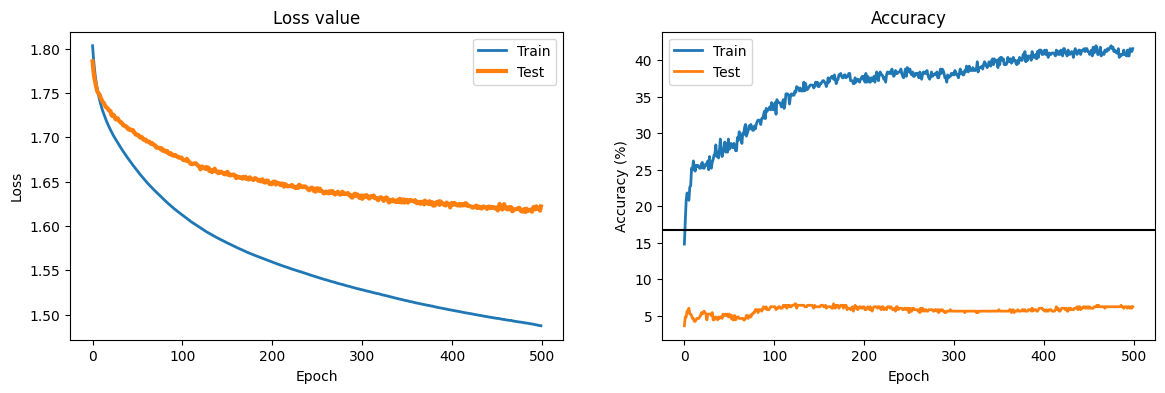

In [12]:
# --------------------------------------------------
# Training
# --------------------------------------------------

def loss_accuracy(x, y, model):
    model.to(device)
    x = x.to(device)
    y = y.to(device)
    pred_y = model(x)
    loss = criterion(pred_y, y.ravel())
    pred_y = pred_y.argmax(dim=1)
    correct = int((pred_y == y.ravel()).sum())
    acc = correct/graph_dataset.standarized_train_X.size()[0]
    return loss.item(), acc

train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []
for j, epoch in enumerate(tqdm(range(epochs))):
    # Training step
    model.train()
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        pred_y = model(X)
        loss = criterion(pred_y, y.ravel())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation step
    model.eval()
    train_loss, train_accuracy = loss_accuracy(graph_dataset.standarized_train_X, graph_dataset.train_y, model)
    test_loss, test_accuracy = loss_accuracy(scaled_test_graph_embedding, test_y, model)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)

# Model evaluation
train_loss, train_accuracy = loss_accuracy(graph_dataset.standarized_train_X, graph_dataset.train_y, model)
test_loss, test_accuracy = loss_accuracy(scaled_test_graph_embedding, test_y, model)
print("")
print("---------------------------------------------------------------")
print(f"Test:       Loss value = {test_loss:.5f}, Accuracy = {test_accuracy*100:.2f}%")
print(f"Training:   Loss value = {train_loss:.5f}, Accuracy = {train_accuracy*100:.2f}%")
print("")

# plot
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
ax[0].plot(train_loss_list, label = "Train", linewidth = 2)
ax[0].plot(test_loss_list, label = "Test", linewidth = 3)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].set_title("Loss value")
ax[1].plot([i*100 for i in train_accuracy_list], label = "Train", linewidth = 2)
ax[1].plot([i*100 for i in test_accuracy_list], label = "Test", linewidth = 2)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title("Accuracy")
ax[1].legend()
ax[1].axhline(100/dataset.num_classes, color = 'k')
plt.show()

# Save accuracy
model_result = pd.concat([
    model_result,
    pd.DataFrame([['MLP', test_accuracy*100]], columns = ['Model', 'Test accuracy'])
])

# Graph convolutional network

In [13]:
# --------------------------------------------------
# Settings
# --------------------------------------------------
batch_size = 64
lr = 0.01
epochs = 500

In [14]:
# --------------------------------------------------
# Model and Dataset
# --------------------------------------------------

# Define model structure
class GCN(nn.Module):
    def __init__(self, d_input, d_hidden1, d_hidden2, d_hidden3, d_output):
        super().__init__()
        self.conv1 = GCNConv(d_input, d_hidden1)
        self.conv2 = GCNConv(d_hidden1, d_hidden2)
        self.conv3 = GCNConv(d_hidden2, d_hidden3)
        self.fc = nn.Linear(d_hidden3, d_output)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = 0.5)

    def forward(self, data):
        # features etc.
        x = data.x
        edge_index = data.edge_index
        batch = data.batch
        # forward
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.conv3(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [15]:
# --------------------------------------------------
# Instantiation of pytorch components
# --------------------------------------------------

# Model
model = GCN(train_dataset.num_node_features, 256, 256, 64, train_dataset.num_classes)
model = model.to(device)

# Dataloader
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = len(test_dataset), shuffle = False)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

100%|██████████| 500/500 [13:20<00:00,  1.60s/it]



---------------------------------------------------------------
Test:       Loss value = 1.88173, Accuracy = 33.00%
Training:   Loss value = 1.55431, Accuracy = 45.20%



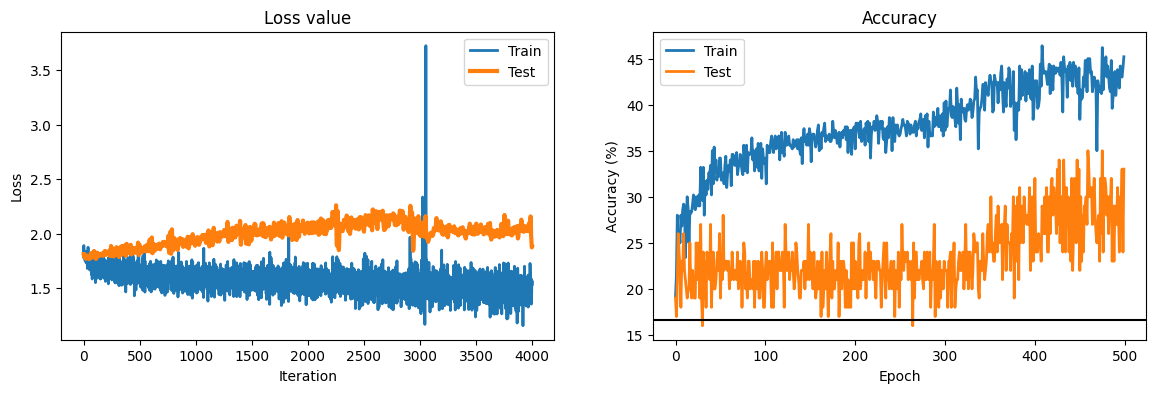

In [16]:
# --------------------------------------------------
# Training
# --------------------------------------------------

# Evaluation funaction
def accuracy(dataloader, model):
    with torch.no_grad():
        correct = 0
        for i, data in enumerate(dataloader):
            data = data.to(device)
            pred_y = model(data)
            pred_y = pred_y.argmax(dim = 1)
            correct += int((pred_y == data.y).sum())
        accuracy = correct/len(dataloader.dataset)
    return accuracy

def loss_value(dataloader, model):
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            pred_y = model(data)
            loss = criterion(pred_y, data.y)
    return loss

# Training
train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []
for j, epoch in enumerate(tqdm(range(epochs))):
    # Training step
    for data in train_loader:
        # Train
        model.train()
        data = data.to(device)
        pred_y = model(data)
        loss = criterion(pred_y, data.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())
        # Loss for test dataset
        model.eval()
        test_loss = loss_value(test_loader, model)
        test_loss_list.append(test_loss.item())

    # Evaluation step
    model.eval()
    train_accuracy = accuracy(train_loader, model)
    test_accuracy = accuracy(test_loader, model)
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)

# Model evaluation
train_accuracy = accuracy(train_loader, model)
test_accuracy = accuracy(test_loader, model)
print("")
print("---------------------------------------------------------------")
print(f"Test:       Loss value = {test_loss_list[-1]:.5f}, Accuracy = {test_accuracy*100:.2f}%")
print(f"Training:   Loss value = {train_loss_list[-1]:.5f}, Accuracy = {train_accuracy*100:.2f}%")
print("")

# plot
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
ax[0].plot(train_loss_list, label = "Train", linewidth = 2)
ax[0].plot(test_loss_list, label = "Test", linewidth = 3)
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].set_title("Loss value")
ax[1].plot([i*100 for i in train_accuracy_list], label = "Train", linewidth = 2)
ax[1].plot([i*100 for i in test_accuracy_list], label = "Test", linewidth = 2)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title("Accuracy")
ax[1].legend()
ax[1].axhline(100/dataset.num_classes, color = 'k')
plt.show()

# Save accuracy
model_result = pd.concat([
    model_result,
    pd.DataFrame([['GCN', test_accuracy*100]], columns = ['Model', 'Test accuracy'])
])

# Graph attension network


In [17]:
# --------------------------------------------------
# Settings
# --------------------------------------------------
batch_size = 64
lr = 0.01
epochs = 500

In [18]:
# --------------------------------------------------
# Model
# --------------------------------------------------

# Define model structure
class GAT(nn.Module):
    def __init__(self, d_input, d_hidden1, d_hidden2, d_hidden3, d_output, heads, dropout = 0.2):
        super().__init__()
        self.gat1 = GATConv(d_input, d_hidden1, heads = heads, dropout = dropout, concat = True)
        self.gat2 = GATConv(d_hidden1*heads, d_hidden2, heads = heads, dropout = dropout, concat = True)
        self.gat3 = GATConv(d_hidden2*heads, d_hidden3, heads = heads, dropout = dropout, concat = True)
        self.fc = nn.Linear(d_hidden3*heads, d_output)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = 0.2)

    def forward(self, data):
        # features etc.
        x = data.x
        edge_index = data.edge_index
        batch = data.batch
        # forward
        x = self.gat1(x, edge_index)
        x = self.relu(x)
        x = self.gat2(x, edge_index)
        x = self.relu(x)
        x = self.gat3(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [19]:
# --------------------------------------------------
# Instantiation of pytorch components
# --------------------------------------------------

# Model
model = GAT(train_dataset.num_node_features, 64, 64, 16, train_dataset.num_classes, 8)
model = model.to(device)

# Dataloader
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = len(test_dataset), shuffle = False)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

100%|██████████| 500/500 [42:04<00:00,  5.05s/it]



---------------------------------------------------------------
Test:       Loss value = 1.96186, Accuracy = 31.00%
Training:   Loss value = 1.36526, Accuracy = 52.80%



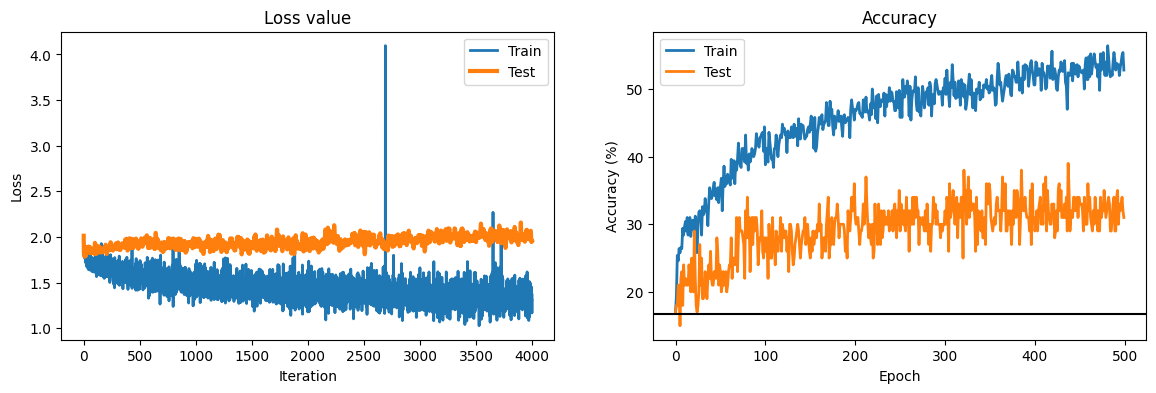

In [20]:
# --------------------------------------------------
# Training
# --------------------------------------------------

# Evaluation funaction
def accuracy(dataloader, model):
    with torch.no_grad():
        correct = 0
        for i, data in enumerate(dataloader):
            data = data.to(device)
            pred_y = model(data)
            pred_y = pred_y.argmax(dim = 1)
            correct += int((pred_y == data.y).sum())
        accuracy = correct/len(dataloader.dataset)
    return accuracy

def loss_value(dataloader, model):
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            pred_y = model(data)
            loss = criterion(pred_y, data.y)
    return loss

# Training
train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []
for j, epoch in enumerate(tqdm(range(epochs))):
    # Training step
    for data in train_loader:
        # Train
        model.train()
        data = data.to(device)
        pred_y = model(data)
        loss = criterion(pred_y, data.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())
        # Loss for test dataset
        model.eval()
        test_loss = loss_value(test_loader, model)
        test_loss_list.append(test_loss.item())

    # Evaluation step
    model.eval()
    train_accuracy = accuracy(train_loader, model)
    test_accuracy = accuracy(test_loader, model)
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)

# Model evaluation
train_accuracy = accuracy(train_loader, model)
test_accuracy = accuracy(test_loader, model)
print("")
print("---------------------------------------------------------------")
print(f"Test:       Loss value = {test_loss_list[-1]:.5f}, Accuracy = {test_accuracy*100:.2f}%")
print(f"Training:   Loss value = {train_loss_list[-1]:.5f}, Accuracy = {train_accuracy*100:.2f}%")
print("")

# plot
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
ax[0].plot(train_loss_list, label = "Train", linewidth = 2)
ax[0].plot(test_loss_list, label = "Test", linewidth = 3)
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].set_title("Loss value")
ax[1].plot([i*100 for i in train_accuracy_list], label = "Train", linewidth = 2)
ax[1].plot([i*100 for i in test_accuracy_list], label = "Test", linewidth = 2)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title("Accuracy")
ax[1].legend()
ax[1].axhline(100/dataset.num_classes, color = 'k')
plt.show()

# Save accuracy
model_result = pd.concat([
    model_result,
    pd.DataFrame([['GAT', test_accuracy*100]], columns = ['Model', 'Test accuracy'])
])

# Graph Isomorphism Network

In [26]:
# --------------------------------------------------
# Settings
# --------------------------------------------------
batch_size = 64
lr = 0.01
epochs = 500
weight_decay = 1e-4

In [27]:
# --------------------------------------------------
# Model
# --------------------------------------------------

# Define model structure
class MLP(nn.Module):
    def __init__(self, d_input, d_hidden1, d_output):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(d_input, d_hidden1),
            nn.BatchNorm1d(d_hidden1),
            nn.ReLU(),
            nn.Linear(d_hidden1, d_output),
            nn.BatchNorm1d(d_output),
            nn.ReLU()
        )

    def forward(self, input):
        return self.main(input)

class GIN(nn.Module):
    def __init__(self, d_input, d_hidden1, d_output):
        super(GIN, self).__init__()

        self.first_layer = MLP(d_input, d_hidden1, d_hidden1)
        self.conv1 = GINConv(MLP(d_hidden1, d_hidden1, d_hidden1))
        self.conv2 = GINConv(MLP(d_hidden1, d_hidden1, d_hidden1))
        self.conv3 = GINConv(MLP(d_hidden1, d_hidden1, d_hidden1))
        self.predictor = nn.Sequential(
            nn.Linear(d_hidden1, d_hidden1),
            nn.BatchNorm1d(d_hidden1),
            nn.ReLU(),
            nn.Linear(d_hidden1, d_output),
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.first_layer(x)
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)
        graph_embeddings = scatter(x, batch, dim = 0, reduce = 'max')
        res = self.predictor(graph_embeddings)
        return F.log_softmax(res, dim = 1)

In [28]:
# --------------------------------------------------
# Instantiation of pytorch components
# --------------------------------------------------

# Model
model = GIN(dataset.num_node_features, 32, dataset.num_classes)
model = model.to(device)

# Dataloader
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = len(test_dataset), shuffle = False)

# Loss function
criterion = nn.NLLLoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay = weight_decay)

100%|██████████| 500/500 [03:43<00:00,  2.24it/s]



---------------------------------------------------------------
Test:       Loss value = 1.93896, Accuracy = 53.00%
Training:   Loss value = 0.06349, Accuracy = 100.00%



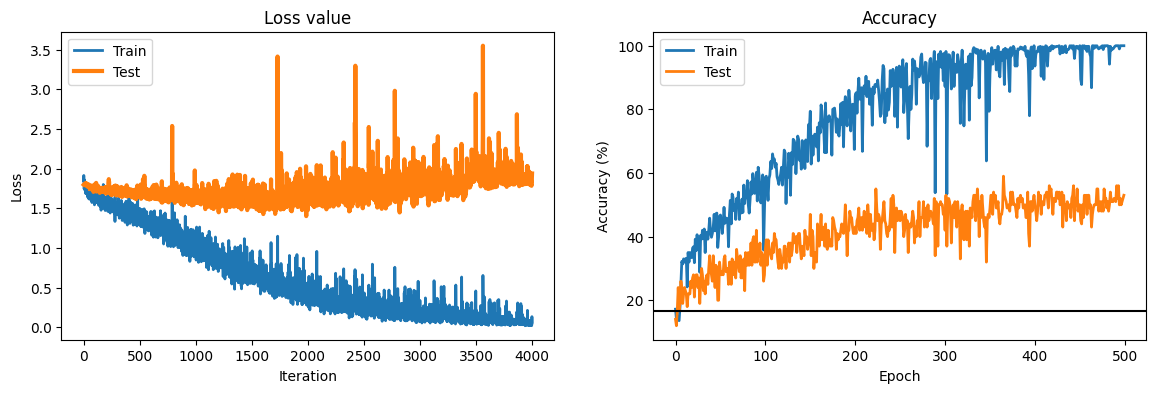

In [29]:
# --------------------------------------------------
# Training
# --------------------------------------------------

# Evaluation funaction
def accuracy(dataloader, model):
    with torch.no_grad():
        correct = 0
        for i, data in enumerate(dataloader):
            data = data.to(device)
            pred_y = model(data)
            pred_y = pred_y.argmax(dim = 1)
            correct += int((pred_y == data.y).sum())
        accuracy = correct/len(dataloader.dataset)
    return accuracy

def loss_value(dataloader, model):
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            pred_y = model(data)
            loss = criterion(pred_y, data.y)
    return loss

# Training
train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []
for epoch in tqdm(range(epochs)):
    # Training step
    for data in train_loader:
        # Train
        model.train()
        data = data.to(device)
        pred_y = model(data)
        loss = criterion(pred_y, data.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())
        # Loss for test dataset
        model.eval()
        test_loss = loss_value(test_loader, model)
        test_loss_list.append(test_loss.item())

    # Evaluation step
    model.eval()
    train_accuracy = accuracy(train_loader, model)
    test_accuracy = accuracy(test_loader, model)
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)

# Model evaluation
train_accuracy = accuracy(train_loader, model)
test_accuracy = accuracy(test_loader, model)
print("")
print("---------------------------------------------------------------")
print(f"Test:       Loss value = {test_loss_list[-1]:.5f}, Accuracy = {test_accuracy*100:.2f}%")
print(f"Training:   Loss value = {train_loss_list[-1]:.5f}, Accuracy = {train_accuracy*100:.2f}%")
print("")

# plot
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
ax[0].plot(train_loss_list, label = "Train", linewidth = 2)
ax[0].plot(test_loss_list, label = "Test", linewidth = 3)
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].set_title("Loss value")
ax[1].plot([i*100 for i in train_accuracy_list], label = "Train", linewidth = 2)
ax[1].plot([i*100 for i in test_accuracy_list], label = "Test", linewidth = 2)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title("Accuracy")
ax[1].legend()
ax[1].axhline(100/dataset.num_classes, color = 'k')
plt.show()

# Save accuracy
model_result = pd.concat([
    model_result,
    pd.DataFrame([['GIN', test_accuracy*100]], columns = ['Model', 'Test accuracy'])
])

# Result

In [25]:
model_result.sort_values("Test accuracy", ascending = False)

,Model,Test accuracy
0,GIN,51.0
0,GCN,33.0
0,GAT,31.0
0,MLP,6.2
